In [2]:
import pandas as pd

df = pd.read_csv("credit_card_default_analysis.csv", sep=",", header=0)
print("Data shape: (rows:{}, cols:{})".format(df.shape[0], df.shape[1]))
df.head()

Data shape: (rows:30000, cols:25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


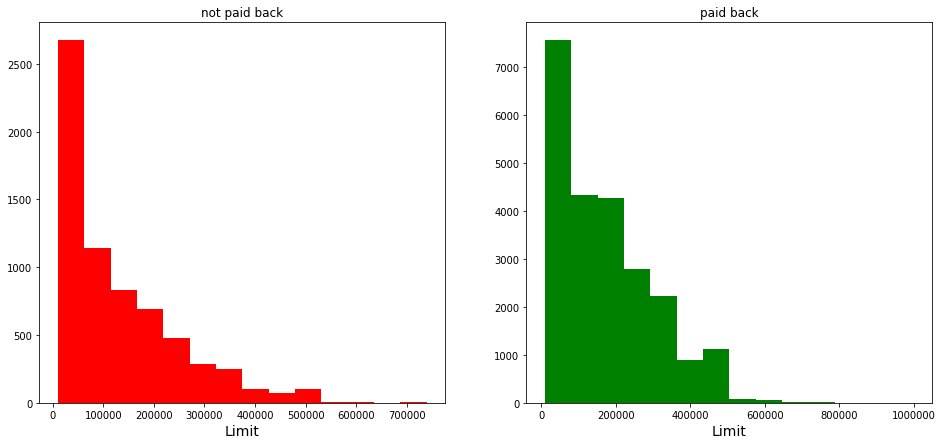

In [7]:
import matplotlib.pyplot as plt

limits_def_on  = df[df.default == 1].LIMIT_BAL.values
limits_def_off = df[df.default != 1].LIMIT_BAL.values
plt.figure(figsize=(16, 7))
plt.subplot(121)
plt.hist(limits_def_on, bins=14, color = 'r')
plt.xlabel('Limit', fontsize=14)
plt.title("not paid back")

plt.subplot(122)
plt.hist(limits_def_off, bins=14, color = 'g')
plt.xlabel('Limit', fontsize=14)
plt.title("paid back")
plt.show()

In [11]:
import numpy as np

boostrap_size = 20000

def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


#Интервальная оценка медиан
np.random.seed(0)

medians_def_on  = map(np.median, get_bootstrap_samples(limits_def_on,  boostrap_size))
medians_def_off = map(np.median, get_bootstrap_samples(limits_def_off, boostrap_size))

In [12]:
from statsmodels.stats.weightstats import zconfint

conf_on  = zconfint(medians_def_on)
conf_off = zconfint(medians_def_off)

print "95% confidence interval and median:"
print "Default == 1: {:10.2f} -> [{:4.2f}, {:4.2f}]".format(np.mean(medians_def_on), conf_on[0], conf_on[1])
print "Default == 0: {:10.2f} -> [{:4.2f}, {:4.2f}]".format(np.mean(medians_def_off), conf_off[0], conf_off[1])

95% confidence interval and median:
Default == 1:   89716.00 -> [89685.50, 89746.50]
Default == 0:  150035.25 -> [150027.05, 150043.45]


In [17]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

print "Difference between medians:", np.median(limits_def_off) - np.median(limits_def_on)
delta_medians = map(lambda x: x[0] - x[1], zip(medians_def_off, medians_def_on))
print "95% confidence interval for the difference between medians",  stat_intervals(delta_medians, 0.05)
del delta_medians


 Difference between medians: 60000.0
95% confidence interval for the difference between medians [60000. 70000.]


In [18]:
#Для начала получим точечную оценку среднего, а также интервальную оценку для каждой выборки
conf_on = zconfint(limits_def_on)
conf_off = zconfint(limits_def_off)

print "95% confidence interval and mean:"
print "Default == 1: {:10.2f} -> [{:10.2f}, {:10.2f}]".format(limits_def_on.mean(), conf_on[0], conf_on[1])
print "Default == 0: {:10.2f} -> [{:10.2f}, {:10.2f}]".format(limits_def_off.mean(), conf_off[0], conf_off[1])

del conf_on
del conf_off

95% confidence interval and mean:
Default == 1:  130109.66 -> [ 127333.65,  132885.66]
Default == 0:  178099.73 -> [ 176411.91,  179787.54]


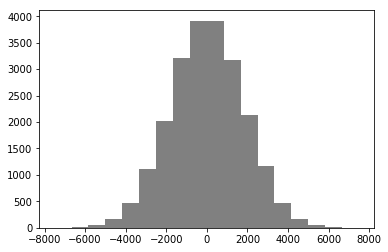

In [21]:
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]


def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() for i in indices]
    
    t_stat = np.mean(sample1) - np.mean(sample2)
    
    return distr, t_stat


permutations = 22000

perm, t_stat = permutation_zero_dist_ind(limits_def_off, limits_def_on, max_combinations = permutations)

plt.hist(perm, bins=18, range=(-7500, 7500), color='gray')
plt.show()

In [23]:
def permutation_test(zero_distr, t_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    
print "p-value: %f" % permutation_test(perm, t_stat)

p-value: 0.000045


In [24]:
del limits_def_on
del limits_def_off

del medians_def_on
del medians_def_off

del perm

### <font color="green">Выводы 01: Анализ размера кредитного лимита (LIMIT_BAL)</font>

__Проверка гипотезы о равенстве распределений:__

__1. Интервальная оценка равенства медианных значений кредитного лимита:__
- Интервальная оценка медиан дает два непересекающихся интервала. Причем, интервал для медианы кредитного лимита тех, кто вернул кредит, лежит сильно правее интервала для медианного значения кредитного лимита у тех, кто его не вернул.
- Интервальные оценка разности двух медиан не содержит 0.

__2. Применение непараметрического критерия проверки равенства средних значений кредитного лимита.__

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

- Вычисленные достигаемый уровень значимости $p \ll 0.05$, следовательно, отвергаем $H_0$ о том, что средние значения равны.

__3. Общий вывод:__
- Распределения получаются разные, следовательно, природа событий, порождающих эти две выборки разная
- С практической точки зрения результат говорит о том, что банк не страдает от невозвратных кредитов, находясь при этом в плюсе, т.к. кредитный лимит у людей, кто не вернул, значительно ниже.

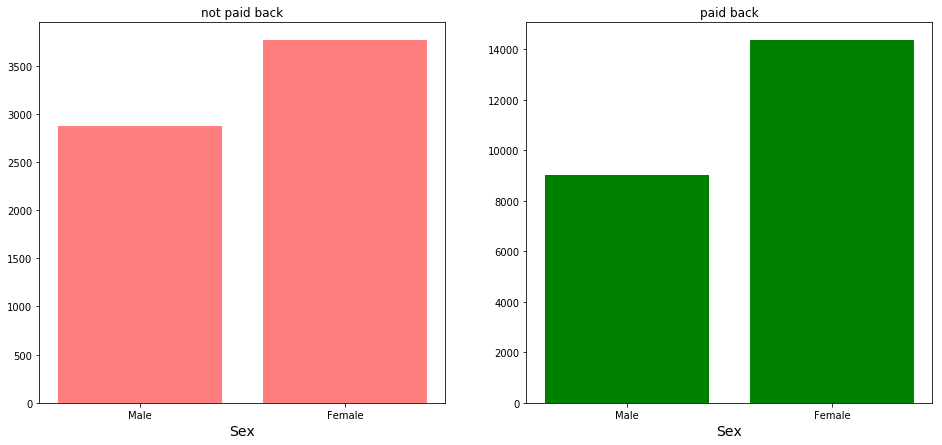

In [26]:
sex_def_on  = df[df.default == 1].SEX.values - 1
sex_def_off = df[df.default == 0].SEX.values - 1

unique1, counts1 = np.unique(sex_def_on, return_counts=True)
unique2, counts2 = np.unique(sex_def_off, return_counts=True)

sex_dic = {0: "Male", 1 :"Female"}

unique1 = [sex_dic[idx] for idx in unique1]
unique2 = [sex_dic[idx] for idx in unique2]

y_pos1 = np.arange(len(unique1))
y_pos2 = np.arange(len(unique2))

plt.figure(figsize=(16, 7))
plt.subplot(121)

plt.bar(y_pos1, counts1, color = 'r', align='center', alpha=0.5)
plt.xlabel('Sex', fontsize=14)
plt.title("not paid back")
plt.xticks(y_pos1, unique1)

plt.subplot(122)
plt.bar(y_pos2, counts2, color = 'g')
plt.xlabel('Sex', fontsize=14)
plt.title("paid back")
plt.xticks(y_pos2, unique2)
plt.show()

a) Интервальная оценка:
Выборки являются независимыми и бинарными. Присутствуют всего два значения: мужчина, женщина. Следовательно, можно использовать оценку доверительных интервалов для разности долей

In [29]:
from statsmodels.stats.proportion import proportion_confint

print "Female ratio (Default == 1): {}/{} ".format(sex_def_on.sum(),  sex_def_on.shape[0])
print "Female ratio (Default == 0): {}/{} ".format(sex_def_off.sum(), sex_def_off.shape[0])

conf_on  = proportion_confint(sex_def_on.sum(),  sex_def_on.shape[0],  method = 'wilson')
conf_off = proportion_confint(sex_def_off.sum(), sex_def_off.shape[0], method = 'wilson')

print "\n95% confidence interval:"
print 'Female (Default == 1): {:1.4f} -> [{:1.4f}, {:1.4f}]'.format(sex_def_on.mean(), conf_on[0], conf_on[1])
print 'Female (Default == 0): {:1.4f} -> [{:1.4f}, {:1.4f}]'.format(sex_def_off.mean(), conf_off[0], conf_off[1])

Female ratio (Default == 1): 3763/6636 
Female ratio (Default == 0): 14349/23364 

95% confidence interval:
Female (Default == 1): 0.5671 -> [0.5551, 0.5789]
Female (Default == 0): 0.6141 -> [0.6079, 0.6204]


In [32]:
from scipy.stats import norm


def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = norm.ppf(1 - alpha / 2.0)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary  = (p1 - p2) - z * np.sqrt(p1 * (1 - p1) / len(sample1) + p2 * (1 - p2) / len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1) / len(sample1) + p2 * (1 - p2) / len(sample2))
    
    return (left_boundary, right_boundary)


print "\nDifference (def=0 - def=1): {:4.4f}".format(sex_def_off.mean() - sex_def_on.mean())

print "95%% confidence interval for a diff: [%f, %f]" % proportions_diff_confint_ind(sex_def_off, sex_def_on)


Difference (def=0 - def=1): 0.0471
95% confidence interval for a diff: [0.033635, 0.060548]


Видим, что интервалы опять же не пересекаются. Вроде как, женщины чаще возвращают кредит, чем мужчины. Причем возвращающих кредит женщин больше на  4.7% , чем женщин, не возращающих кредит. Проверим это с помощью статистического критерия.



In [35]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - norm.cdf(z_stat)
    

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1))  / n1
    p2 = float(sum(sample2))  / n2 
    P  = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))


z = proportions_diff_z_stat_ind(sex_def_off, sex_def_on)
print "p-value: {}".format(proportions_diff_z_test(z, "less"))

p-value: 0.999999999998


In [36]:
del sex_def_on
del sex_def_off
del unique1, counts1
del unique2, counts2
del sex_dic
del y_pos1, y_pos2
del conf_on
del conf_off

Выводы 02: Пол (SEX)
Гендерный состав в группах людей, вернуших кредит и не вернувших кредит, разный
Женщины возвращают кредит чаще, чем мужчины.
Количество женщин, вернувших кредит в среднем на  4.7%   (95%  доверительный интервал —  [3.36%,6.05%] ) больше, чем женщин, не вернувших кредит

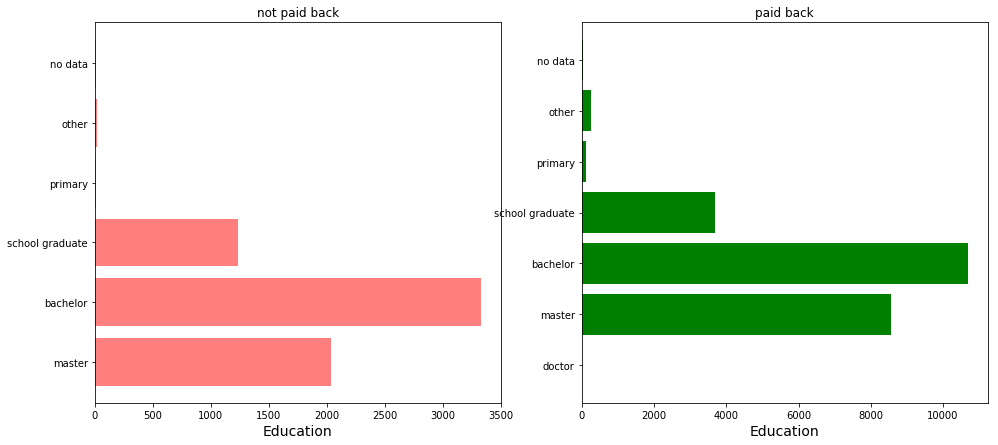

In [38]:
education_def_on  = df[df.default == 1].EDUCATION
education_def_off = df[df.default == 0].EDUCATION

unique1, counts1 = np.unique(education_def_on,  return_counts=True)
unique2, counts2 = np.unique(education_def_off, return_counts=True)

edu_dic = {0: "doctor", 1 :"master", 2: "bachelor", 3: "school graduate", 4: "primary", 5: "other", 6: "no data"}

unique1 = [edu_dic[idx] for idx in unique1]
unique2 = [edu_dic[idx] for idx in unique2]

y_pos1 = np.arange(len(unique1))
y_pos2 = np.arange(len(unique2))

plt.figure(figsize=(16, 7))
plt.subplot(121)

plt.barh(y_pos1, counts1, color = 'r', align='center', alpha=0.5)
plt.xlabel('Education', fontsize=14)
plt.title("not paid back")
plt.yticks(y_pos1, unique1)

plt.subplot(122)
plt.barh(y_pos2, counts2, color = 'g')
plt.xlabel('Education', fontsize=14)
plt.title("paid back")
plt.yticks(y_pos2, unique2)
plt.show()



In [41]:
from scipy.stats import chi2_contingency


def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    (chi2, p, dof, ex) = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1))), p

def cramers_stat(confusion_matrix):
    (chi2, p, dof, ex) = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1))), p


confusion_matrix = pd.crosstab(df['default'], df['EDUCATION']).as_matrix()

print "Cramers Vcorr=%f, p=%2.8f" % cramers_corrected_stat(confusion_matrix)
print "Cramers Vorig=%f, p=%2.8f" % cramers_stat(confusion_matrix)

Cramers Vcorr=0.073760, p=0.00000000
Cramers Vorig=0.073760, p=0.00000000


C:\Python27\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


После применения вычисления коэффициента корреляции V Краммера и достигаемого уровня значимости, мы видим, то гипотезу  𝐻0  можно смело отвергнуть.

In [43]:
from scipy.stats.contingency import expected_freq

#Получаем матрицу сопряженности с разностью между наблюдаемым и ожидаемым количеством человек
ex_freq = expected_freq(confusion_matrix)
conjugacy_matrix = confusion_matrix - ex_freq
#Нормируем матрицу
conjugacy_matrix_norm = conjugacy_matrix / ex_freq#confusion_matrix.sum(axis=0)

confusion_df = pd.DataFrame(data=confusion_matrix, columns=unique2, index=["def=0", "def=1"])
confusion_df

,doctor,master,bachelor,school graduate,primary,other,no data
def=0,14,8549,10700,3680,116,262,43
def=1,0,2036,3330,1237,7,18,8


In [44]:
ex_freq_df = pd.DataFrame(data=ex_freq, columns=unique2, index=["def=0", "def=1"])
ex_freq_df

,doctor,master,bachelor,school graduate,primary,other,no data
def=0,10.9032,8243.598,10926.564,3829.3596,95.7924,218.064,39.7188
def=1,3.0968,2341.402,3103.436,1087.6404,27.2076,61.936,11.2812


In [45]:
conjugacy_df = pd.DataFrame(data=conjugacy_matrix_norm, columns=unique2, index=["def=0", "def=1"])
conjugacy_df

,doctor,master,bachelor,school graduate,primary,other,no data
def=0,0.284027,0.037047,-0.020735,-0.039004,0.210952,0.201482,0.082611
def=1,-1.000000,-0.130436,0.073004,0.137324,-0.742719,-0.709377,-0.290856


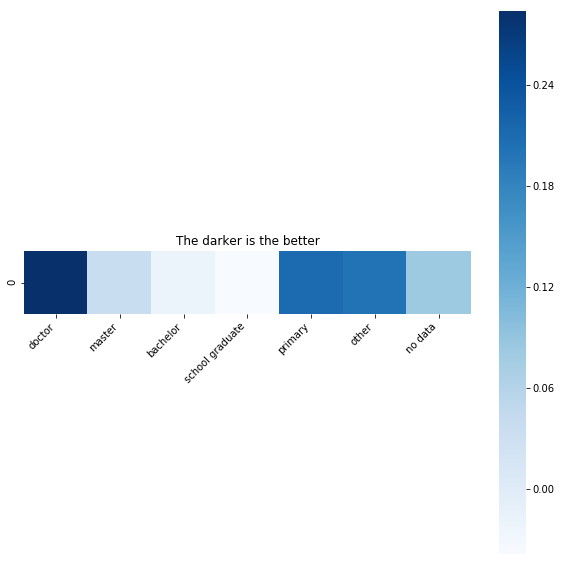

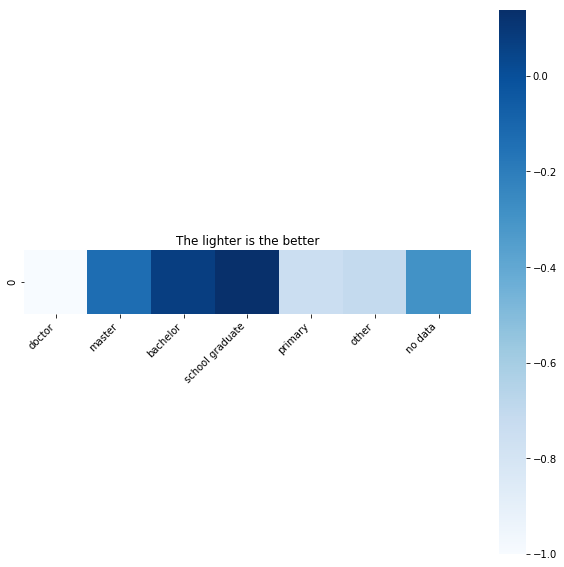

In [47]:
from seaborn import heatmap

heatmap_matrix = conjugacy_matrix_norm
plt.figure(figsize=(10, 10))
ax = heatmap([heatmap_matrix[0]], square=True, cmap="Blues")
ax.set_xticklabels(unique2, rotation=45, ha='right', minor=False)
plt.title("The darker is the better")
plt.show()

heatmap_matrix = conjugacy_matrix_norm
plt.figure(figsize=(10, 10))
ax = heatmap([heatmap_matrix[1]], square=True, cmap="Blues")
ax.set_xticklabels(unique2, rotation=45, ha='right', minor=False)
plt.title("The lighter is the better")
plt.show()

Глядя на представленную карту, можно сказать, что больше всего проблем с возратом кредитов у людей, имеющих scholl graduate и bachelor. Менее всего проблем у докторов наук.

Выводы 03: Образование (EDUCATION) 
Не видная на первый вгляд корреляция между образованием и значением default все же есть.
Коээфициент корреляции V Краммера отличен от 0 и составляет 0.074 - слабая корреляция
Люди, имеющие school graduate и bachelor, хуже всего возращают долг
Лица со степенью доктора наук лучше остальных отдают долг

In [48]:
del education_def_on
del education_def_off

del unique1, counts1
del unique2, counts2
del y_pos1, y_pos2

del edu_dic

del confusion_matrix
del ex_freq
del conjugacy_matrix
del conjugacy_matrix_norm

del confusion_df, ex_freq_df, conjugacy_df, heatmap_matrix, ax

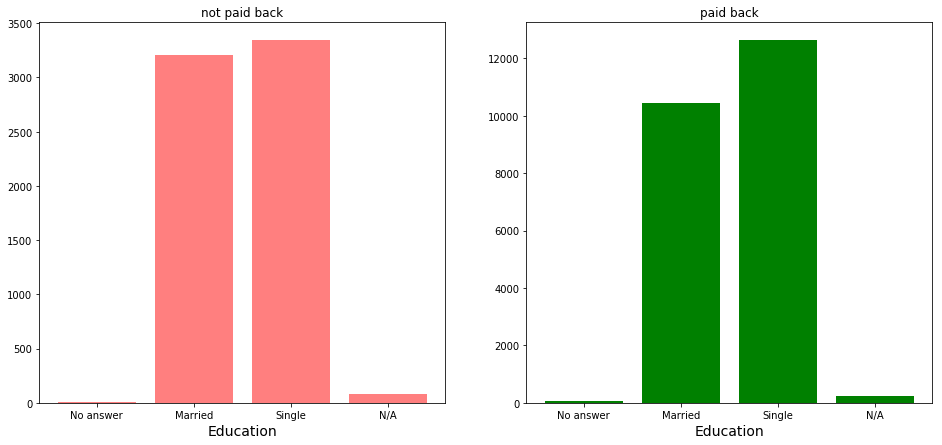

In [51]:
mariage_def_on  = df[df.default == 1].MARRIAGE
mariage_def_off = df[df.default == 0].MARRIAGE
unique1, counts1 = np.unique(mariage_def_on,  return_counts=True)
unique2, counts2 = np.unique(mariage_def_off, return_counts=True)

mariage_dic = {0: "No answer", 1 :"Married", 2: "Single", 3: "N/A"}

unique1 = [mariage_dic[idx] for idx in unique1]
unique2 = [mariage_dic[idx] for idx in unique2]

y_pos1 = np.arange(len(unique1))
y_pos2 = np.arange(len(unique2))

plt.figure(figsize=(16, 7))
plt.subplot(121)

plt.bar(y_pos1, counts1, color = 'r', align='center', alpha=0.5)
plt.xlabel('Education', fontsize=14)
plt.title("not paid back")
plt.xticks(y_pos1, unique1)

plt.subplot(122)
plt.bar(y_pos2, counts2, color = 'g')
plt.xlabel('Education', fontsize=14)
plt.title("paid back")
plt.xticks(y_pos2, unique2)
plt.show()

In [53]:
confusion_matrix = pd.crosstab(df['default'], df['MARRIAGE']).as_matrix()

print "Cramers Vcorr=%f, p=%2.8f" % cramers_corrected_stat(confusion_matrix)
print "Cramers Vorig=%f, p=%2.8f" % cramers_stat(confusion_matrix)

#Получаем матрицу сопряженности с разностью между наблюдаемым и ожидаемым количеством человек
ex_freq = expected_freq(confusion_matrix)
conjugacy_matrix = confusion_matrix - ex_freq

#Нормируем матрицу и рисуем "тепловую карту"
conjugacy_matrix_norm = conjugacy_matrix / confusion_matrix.sum(axis=0)



Cramers Vcorr=0.034478, p=0.00000009
Cramers Vorig=0.034478, p=0.00000009


C:\Python27\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [54]:
confusion_df = pd.DataFrame(data=confusion_matrix, columns=unique2, index=["def=0", "def=1"])
confusion_df

,No answer,Married,Single,N/A
def=0,49,10453,12623,239
def=1,5,3206,3341,84


In [55]:
ex_freq_df = pd.DataFrame(data=ex_freq, columns=unique2, index=["def=0", "def=1"])
ex_freq_df

,No answer,Married,Single,N/A
def=0,42.0552,10637.6292,12432.7632,251.5524
def=1,11.9448,3021.3708,3531.2368,71.4476


In [56]:
conjugacy_df = pd.DataFrame(data=conjugacy_matrix_norm, columns=unique2, index=["def=0", "def=1"])
conjugacy_df

,No answer,Married,Single,N/A
def=0,0.128607,-0.013517,0.011917,-0.038862
def=1,-0.128607,0.013517,-0.011917,0.038862


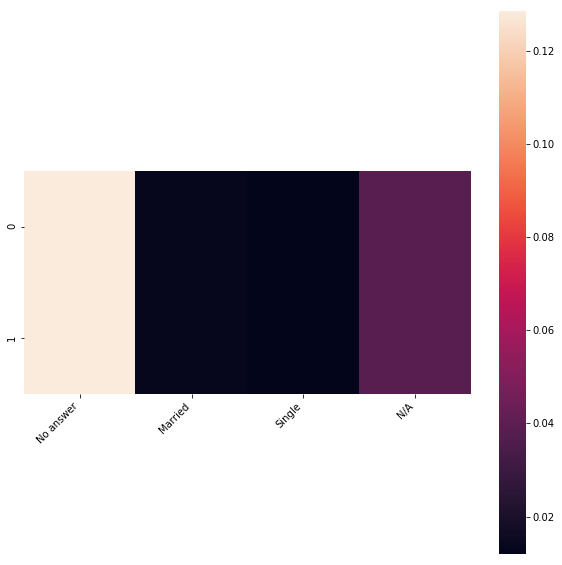

In [57]:
heatmap_matrix = np.abs(conjugacy_matrix_norm)
plt.figure(figsize=(10, 10))
ax = heatmap(heatmap_matrix, square=True)
ax.set_xticklabels(unique1, rotation=45, ha='right', minor=False)
plt.show()

На этой тепловой карте видно, что те, кто скрывает свой статус, скорее всего не вернут кредит, чем тем, кто его не скрывают.



Выводы 04: Семейное положение (MARRIAGE) 
Зависимость между семейным положением и статусом возврата кредита есть
Коэффициент корреляции V Краммера составляет 0.034 - слабая корреляция
Основной вывод: если человек скрывает свое семейное положение, то он скорее всего не вернет кредит.


In [58]:
del mariage_def_on
del mariage_def_off

del unique1, counts1
del unique2, counts2
del y_pos1, y_pos2

del mariage_dic

del confusion_matrix
del ex_freq
del conjugacy_matrix
del conjugacy_matrix_norm

del confusion_df, ex_freq_df, conjugacy_df, heatmap_matrix, ax

### Часть 05.  __Возраст (AGE)__

Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: 

1. О равенстве медианных значений возрастов людей 
2. О равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. 

Значимы ли полученные результаты с практической точки зрения ?

In [59]:
age_def_on  = df[df.default == 1].AGE.values
age_def_off = df[df.default == 0].AGE.values

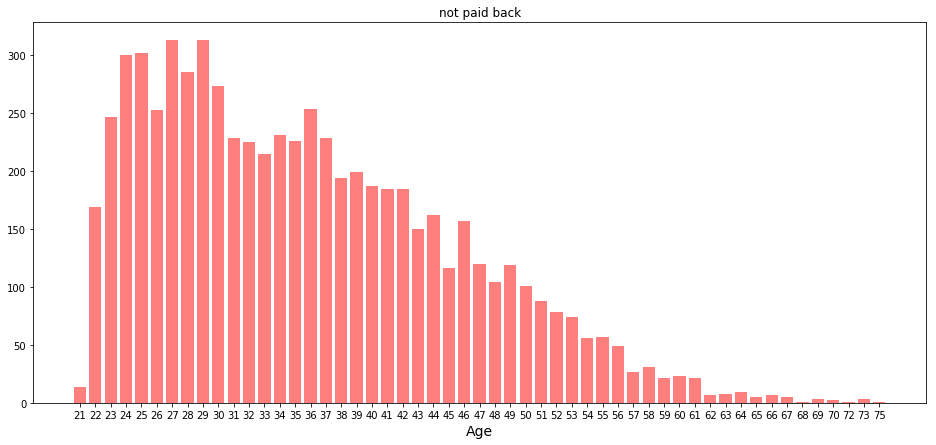

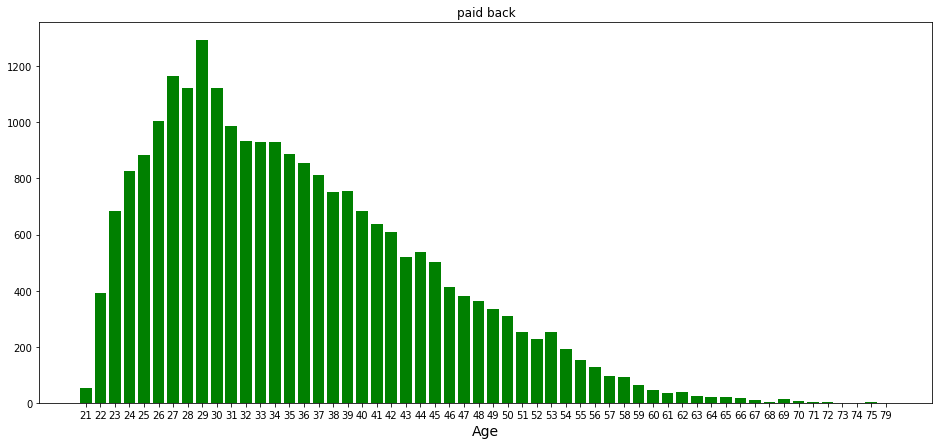

In [61]:
unique1, counts1 = np.unique(age_def_on,  return_counts=True)
unique2, counts2 = np.unique(age_def_off, return_counts=True)

y_pos1 = np.arange(len(unique1))
y_pos2 = np.arange(len(unique2))

plt.figure(figsize=(16, 7))
plt.bar(y_pos1, counts1, color = 'r', align='center', alpha=0.5)
plt.xlabel('Age', fontsize=14)
plt.title("not paid back")
plt.xticks(y_pos1, unique1)
plt.show()

plt.figure(figsize=(16, 7))
plt.bar(y_pos2, counts2, color = 'g')
plt.xlabel('Age', fontsize=14)
plt.title("paid back")
plt.xticks(y_pos2, unique2)
plt.show()

In [62]:
#Интервальная оценка медиан
np.random.seed(0)

medians_def_on  = map(np.median, get_bootstrap_samples(age_def_on,  boostrap_size))
medians_def_off = map(np.median, get_bootstrap_samples(age_def_off, boostrap_size))

In [63]:
conf_on  = zconfint(medians_def_on)
conf_off = zconfint(medians_def_off)

print "95% confidence interval and median:"
print "Default == 1: {:10.2f} -> [{:4.2f}, {:4.2f}]".format(np.mean(medians_def_on), conf_on[0], conf_on[1])
print "Default == 0: {:10.2f} -> [{:4.2f}, {:4.2f}]".format(np.mean(medians_def_off), conf_off[0], conf_off[1])

95% confidence interval and median:
Default == 1:      34.10 -> [34.09, 34.10]
Default == 0:      34.00 -> [34.00, 34.00]


Видно, что интервалы пересекаются, следовательно, необходима дополнительная проверка, чтобы точно быть уверенными.



In [64]:
print "Difference between medians: {:2.4f}".format(np.median(age_def_off) - np.median(age_def_on))
delta_medians = map(lambda x: x[0] - x[1], zip(medians_def_off, medians_def_on))
print "95% confidence interval for the difference between medians:" , stat_intervals(delta_medians, 0.05)
del delta_medians

Difference between medians: 0.0000
95% confidence interval for the difference between medians: [-1.  0.]


Доверительный интервал лежит целиком левее нуля, хотя правая граница очень близка к нулю.



In [65]:
#Для начала получим точечную оценку среднего, а также интервальную оценку для каждой выборки
conf_on = zconfint(age_def_on)
conf_off = zconfint(age_def_off)

print "95% confidence interval and mean:"
print "Default == 1: {:10.2f} -> [{:10.2f}, {:10.2f}]".format(age_def_on.mean(), conf_on[0], conf_on[1])
print "Default == 0: {:10.2f} -> [{:10.2f}, {:10.2f}]".format(age_def_off.mean(), conf_off[0], conf_off[1])

del conf_on
del conf_off

95% confidence interval and mean:
Default == 1:      35.73 -> [     35.49,      35.96]
Default == 0:      35.42 -> [     35.30,      35.53]


Интервальная оценка средних дает два пересекающихся интервала. Проверим равенство средних стат. критерием.

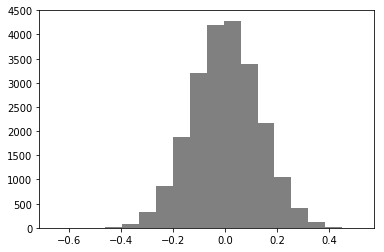

In [66]:
perm, t_stat = permutation_zero_dist_ind(age_def_off, age_def_on, max_combinations = permutations)

plt.hist(perm, bins=18, color='gray')
plt.show()

In [68]:
print "p-value: %f" % permutation_test(perm, t_stat)

p-value: 0.017591


Достигаемый уровень значимости значительно ниже $\alpha = 0.05$. Гипотеза $H_0$ отвергается.
Однако, посмотрим на результат вычислений:

In [69]:
print "Def=1 mean: {:2.4f}".format(np.mean(age_def_on))
print "Def=0 mean: {:2.4f}".format(np.mean(age_def_off))

Def=1 mean: 35.7257
Def=0 mean: 35.4173


Получается, что статистически средний возраст в двух выборках различен, и такой результат статистически значим, но на практике мы видим, что это различие не существенно.

### <font color="green">Выводы 05: __Возраст (AGE)__ </font>

__Проверка гипотезы о равенстве распределений:__

__1. Интервальная оценка равенства медианных значений возрастов клиентов.__
- Медианные значения не различаются.
- Точечная оценка разности медиан составляет 0 при дов. интервале (-1, 0)

__2. Применение непараметрического критерия проверки равенства средних значений возрастов клиентов.__
Проверяем гипотезу

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

- Вычисленный достигаемый уровень значимости $p_value = 0.016$ и $p \ll 0.05$. Следовательно, мы не можем принять гипотезу о равенстве средних.
- Чисто визуально, средние значения отличаются не сильно, потому, возможно, уровень $\alpha = 0.05$ сильно завышен
- С практической точки зрения такая разница в возрастах не имеет значения.

__3. Общий вывод.__
- Проверка на равенство распределений по основным моментам показала, что есть различия.
- С практической точки зрения различия не представляются существенными.